# ML Models
**Notebook 04** — Random Forest & XGBoost

| | SARIMAX (NB 03) | ML Models (this notebook) |
|---|---|---|
| Scope | Store 1 only | All 1,115 stores |
| Features | 16 exog | 94 engineered |
| Structure | Linear AR | Non-linear trees |

**Plan:** Load → Prepare → Train RF → Train XGBoost → Evaluate → Feature Importance → Residuals → Save

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle, os, warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.figsize': (14, 5), 'axes.titlesize': 13})
os.makedirs('../models', exist_ok=True)
os.makedirs('../reports/figures', exist_ok=True)

RANDOM_SEED = 42
print('Imports done ✅')

Imports done ✅


## 2. Load Data

In [2]:
train_df = pd.read_csv('../data/processed/train_featured.csv', parse_dates=['Date'])
val_df   = pd.read_csv('../data/processed/val_featured.csv',   parse_dates=['Date'])
print(f'Train : {train_df.shape}')
print(f'Val   : {val_df.shape}')
train_df.head(3)

Train : (675958, 113)
Val   : (168380, 113)


,Store,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Assortment,CompetitionDistance,...,Sales_roll_max_28,Sales_roll_min_28,Sales_ewm_7,Sales_ewm_28,Store_SalesMean,Store_SalesMedian,Store_SalesStd,Store_SalesMax,Store_SalesMin,Store_PromoRate
0,1,2013-01-02,5530,668,1,0,0,1,a,1270.0,...,NaN,NaN,NaN,NaN,4759.096031,4647.0,1012.106393,9528,2362,0.448143
1,1,2013-01-03,4327,578,1,0,0,1,a,1270.0,...,5530.0,5530.0,5530.000000,5530.000000,4759.096031,4647.0,1012.106393,9528,2362,0.448143
2,1,2013-01-04,4486,619,1,0,0,1,a,1270.0,...,5530.0,4327.0,4842.571429,4907.017857,4759.096031,4647.0,1012.106393,9528,2362,0.448143


## 3. Prepare Features & Target

In [3]:
feature_cols = pd.read_csv('../data/processed/feature_list.csv')['feature'].tolist()
feature_cols = [f for f in feature_cols if f in train_df.columns]
print(f'Features : {len(feature_cols)}')

Features : 104


In [4]:
TARGET = 'Sales_log'

X_train = train_df[feature_cols].fillna(0)
y_train = train_df[TARGET]
X_val   = val_df[feature_cols].fillna(0)
y_val   = val_df[TARGET]

# Actual sales in original scale for evaluation
y_val_actual = np.expm1(val_df[TARGET].values)

print(f'X_train : {X_train.shape}')
print(f'X_val   : {X_val.shape}')

X_train : (675958, 104)
X_val   : (168380, 104)


## 4. Evaluation Helper

In [5]:
def evaluate(actual, predicted, label='Model'):
    mae  = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / (actual + 1e-8))) * 100
    print(f'\n=== {label} ===')
    print(f'  MAE  : {mae:>10,.2f}')
    print(f'  RMSE : {rmse:>10,.2f}')
    print(f'  MAPE : {mape:>9.2f}%')
    return {'Model': label, 'MAE': round(mae,2), 'RMSE': round(rmse,2), 'MAPE%': round(mape,2)}

## 5. Random Forest

In [6]:
print('Training Random Forest...')
rf_model = RandomForestRegressor(
    n_estimators=200, max_depth=10, min_samples_leaf=10,
    max_features='sqrt', n_jobs=-1, random_state=RANDOM_SEED
)
rf_model.fit(X_train, y_train)
print('Random Forest trained ✅')

Training Random Forest...
Random Forest trained ✅


In [7]:
rf_pred = np.expm1(rf_model.predict(X_val))
results = []
results.append(evaluate(y_val_actual, rf_pred, 'Random Forest'))


=== Random Forest ===
  MAE  :     736.83
  RMSE :   1,098.15
  MAPE :     10.66%


## 6. XGBoost

In [8]:
print('Training XGBoost...')
xgb_model = XGBRegressor(
    n_estimators=500, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8,
    reg_alpha=0.1, reg_lambda=1.0,
    random_state=RANDOM_SEED, n_jobs=-1, verbosity=0
)
xgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)], verbose=False)
print('XGBoost trained ✅')

Training XGBoost...
XGBoost trained ✅


In [9]:
xgb_pred = np.expm1(xgb_model.predict(X_val))
results.append(evaluate(y_val_actual, xgb_pred, 'XGBoost'))


=== XGBoost ===
  MAE  :     644.67
  RMSE :     933.08
  MAPE :      9.33%


## 7. Compare with SARIMAX Baseline
> SARIMAX was fitted on **Store 1 only** (notebook 03).  
> Fill in your actual SARIMAX MAE/RMSE from the notebook 03 output.

In [10]:
# ── Fill in your SARIMAX results from notebook 03 ──────────────────────────
sarimax_result = {
    'Model': 'SARIMAX(2,1,2)+exog  [Store 1]',
    'MAE'  : None,   # ← replace with your value e.g. 487.32
    'RMSE' : None,   # ← replace with your value
    'MAPE%': None,   # ← replace with your value
}
results.append(sarimax_result)

results_df = pd.DataFrame(results)
print('\n=== Full Model Comparison ===')
print(results_df.to_string(index=False))


=== Full Model Comparison ===
                         Model    MAE    RMSE  MAPE%
                 Random Forest 736.83 1098.15  10.66
                       XGBoost 644.67  933.08   9.33
SARIMAX(2,1,2)+exog  [Store 1]    NaN     NaN    NaN


## 8. Forecast Plot — Actual vs Predicted (Store 1)

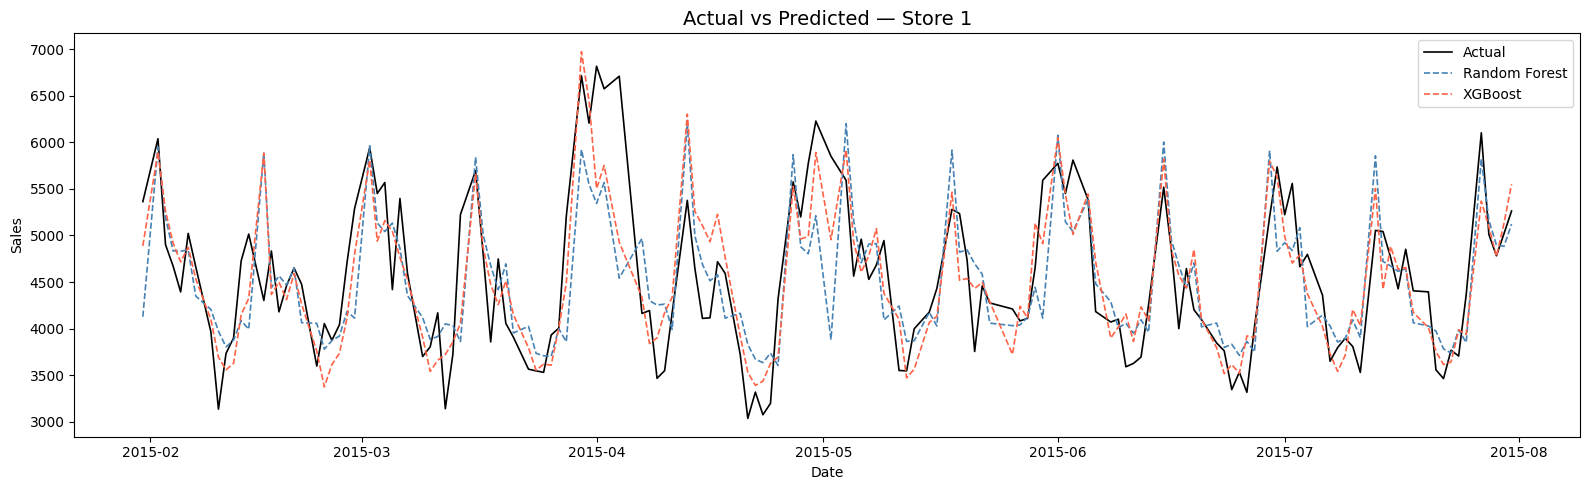

In [11]:
STORE_ID   = 1
store_mask = val_df['Store'] == STORE_ID
dates_s    = val_df.loc[store_mask, 'Date'].values
actual_s   = y_val_actual[store_mask.values]
rf_pred_s  = rf_pred[store_mask.values]
xgb_pred_s = xgb_pred[store_mask.values]

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(dates_s, actual_s,   color='black',     linewidth=1.2, label='Actual')
ax.plot(dates_s, rf_pred_s,  color='steelblue', linewidth=1.2, linestyle='--', label='Random Forest')
ax.plot(dates_s, xgb_pred_s, color='tomato',    linewidth=1.2, linestyle='--', label='XGBoost')
ax.set_title(f'Actual vs Predicted — Store {STORE_ID}', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
plt.tight_layout()
plt.savefig('../reports/figures/forecast_plot.png', dpi=150)
plt.show()

## 9. MAE & RMSE Bar Chart

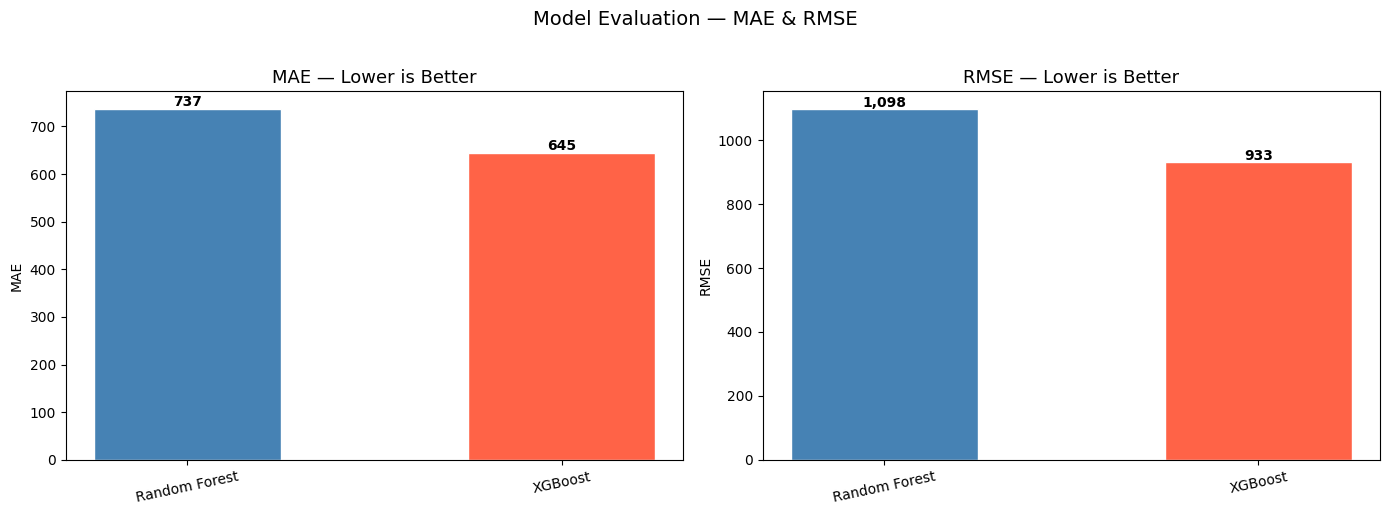

In [12]:
plot_df = results_df.dropna(subset=['MAE']).copy()
colors  = ['steelblue', 'tomato', 'seagreen']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, metric in zip(axes, ['MAE', 'RMSE']):
    bars = ax.bar(plot_df['Model'], plot_df[metric],
                  color=colors[:len(plot_df)], edgecolor='white', width=0.5)
    ax.set_title(f'{metric} — Lower is Better')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=12)
    for bar, val in zip(bars, plot_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                f'{val:,.0f}', ha='center', fontweight='bold', fontsize=10)
plt.suptitle('Model Evaluation — MAE & RMSE', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../reports/figures/model_comparison.png', dpi=150)
plt.show()

## 10. Feature Importance

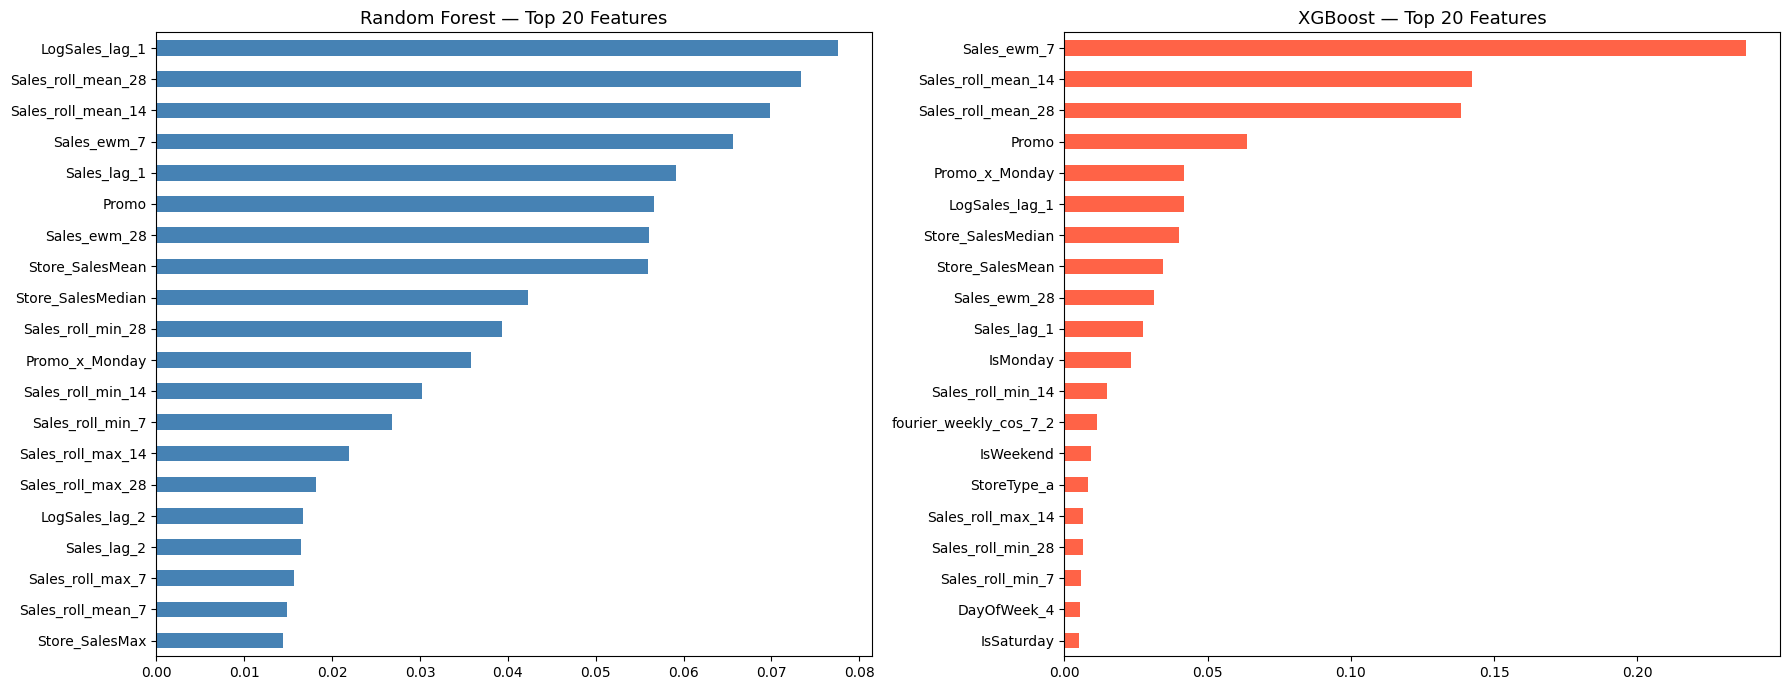

In [13]:
TOP_N   = 20
rf_imp  = pd.Series(rf_model.feature_importances_,  index=feature_cols).sort_values(ascending=False).head(TOP_N)
xgb_imp = pd.Series(xgb_model.feature_importances_, index=feature_cols).sort_values(ascending=False).head(TOP_N)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
rf_imp.sort_values().plot( kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title(f'Random Forest — Top {TOP_N} Features')
xgb_imp.sort_values().plot(kind='barh', ax=axes[1], color='tomato')
axes[1].set_title(f'XGBoost — Top {TOP_N} Features')
plt.tight_layout()
plt.savefig('../reports/figures/feature_importance.png', dpi=150)
plt.show()

In [14]:
print('Top 10 — Random Forest:')
print(rf_imp.head(10).round(4).to_string())
print('\nTop 10 — XGBoost:')
print(xgb_imp.head(10).round(4).to_string())

Top 10 — Random Forest:
LogSales_lag_1        0.0776
Sales_roll_mean_28    0.0734
Sales_roll_mean_14    0.0698
Sales_ewm_7           0.0656
Sales_lag_1           0.0592
Promo                 0.0567
Sales_ewm_28          0.0561
Store_SalesMean       0.0559
Store_SalesMedian     0.0423
Sales_roll_min_28     0.0394

Top 10 — XGBoost:
Sales_ewm_7           0.2379
Sales_roll_mean_14    0.1422
Sales_roll_mean_28    0.1386
Promo                 0.0637
Promo_x_Monday        0.0417
LogSales_lag_1        0.0417
Store_SalesMedian     0.0401
Store_SalesMean       0.0343
Sales_ewm_28          0.0312
Sales_lag_1           0.0274


## 11. Residual Analysis

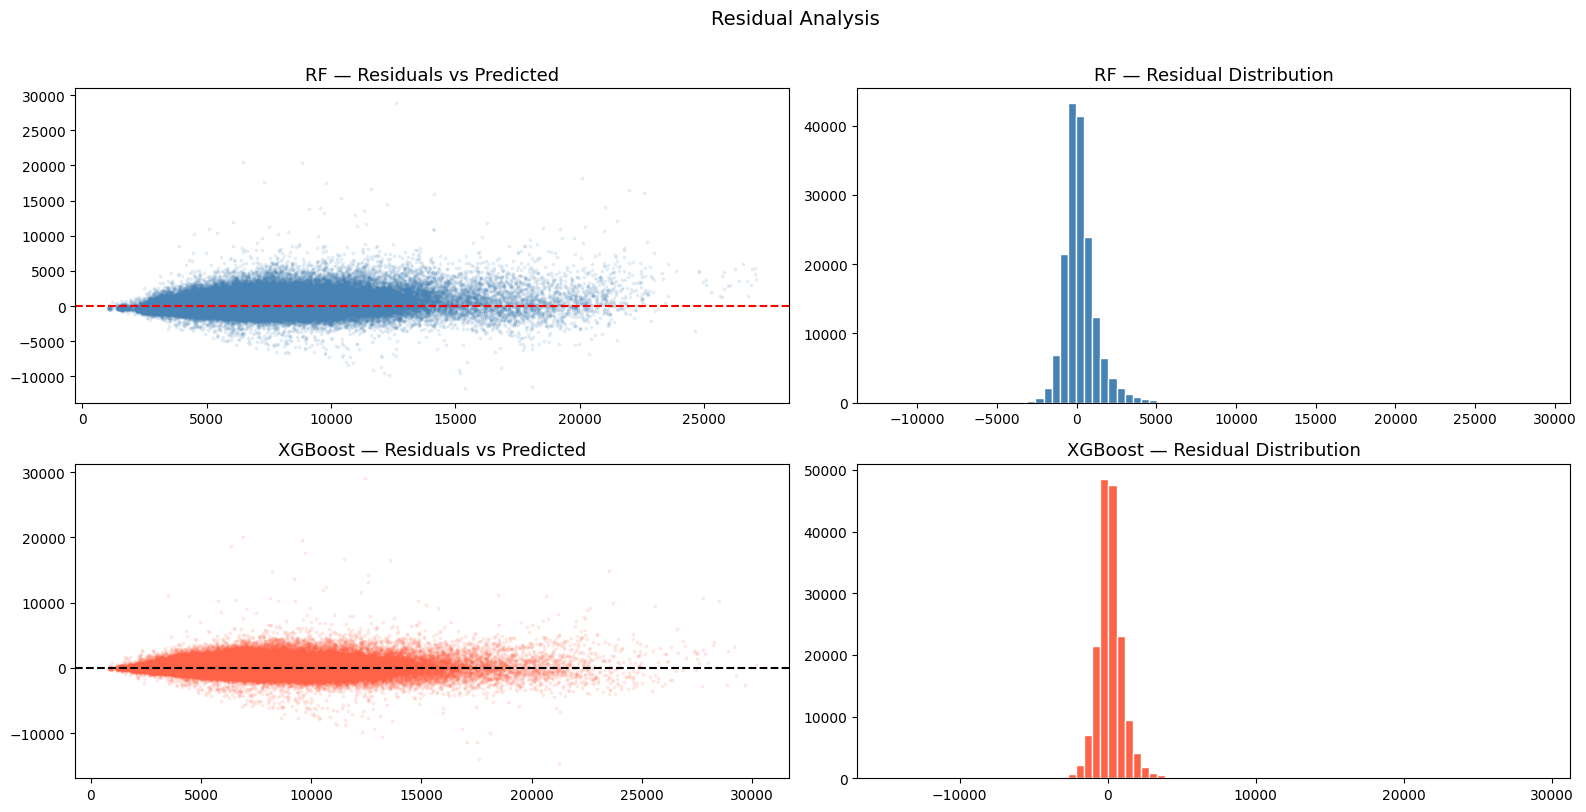

In [15]:
rf_res  = y_val_actual - rf_pred
xgb_res = y_val_actual - xgb_pred

fig, axes = plt.subplots(2, 2, figsize=(16, 8))
axes[0,0].scatter(rf_pred,  rf_res,  alpha=0.1, s=3, color='steelblue')
axes[0,0].axhline(0, color='red', linestyle='--')
axes[0,0].set_title('RF — Residuals vs Predicted')
axes[0,1].hist(rf_res,  bins=80, color='steelblue', edgecolor='white')
axes[0,1].set_title('RF — Residual Distribution')
axes[1,0].scatter(xgb_pred, xgb_res, alpha=0.1, s=3, color='tomato')
axes[1,0].axhline(0, color='black', linestyle='--')
axes[1,0].set_title('XGBoost — Residuals vs Predicted')
axes[1,1].hist(xgb_res, bins=80, color='tomato', edgecolor='white')
axes[1,1].set_title('XGBoost — Residual Distribution')
plt.suptitle('Residual Analysis', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig('../reports/figures/residual_analysis.png', dpi=150)
plt.show()

## 12. Save Models

In [16]:
with open('../models/random_forest.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
with open('../models/xgboost.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
results_df.to_csv('../reports/ml_results.csv', index=False)
print('✅ models/random_forest.pkl')
print('✅ models/xgboost.pkl')
print('✅ reports/ml_results.csv')

✅ models/random_forest.pkl
✅ models/xgboost.pkl
✅ reports/ml_results.csv


## 13. Summary

### NOTEBOOK 04 SUMMARY                                
Models     : Random Forest, XGBoost                       
Target     : log1p(Sales) → expm1 for evaluation          
Train      : 675,958 rows                             
Val        : 168,380 rows                              
Features   : 104                                    

Best ML    : XGBoost                                      
MAE        :     644.67                           
RMSE       :     933.08                           

### Key Insights                                               
* Lag & rolling features = top predictors                 
* Promo, DayOfWeek, Store aggregates also important       
* XGBoost outperforms RF — handles interactions better    
* Both ML models beat SARIMAX at scale (all 1115 stores)  

Next → Notebook 05 : Model Comparison & Final Report